In [1]:
import torch
import torch.nn as nn 
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns
import scipy 

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

import sys
sys.path.append('..')

from classes import MLP, MultiTaskLoss
from utils import non_markovian_midprice

/Users/nicholasmartin/Programming/Research/optimal-execution-kernel-decomposition/venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
config = Config('config.yaml')

In [3]:
rng = np.random.default_rng(123)

num_paths = config.num_paths
num_timesteps = config.num_timesteps
final_time = config.final_time
initial_price = config.initial_price
decomp_dim = config.decomp_dim
num_episodes = config.num_episodes
batch_size = config.batch_size
learning_rate = config.learning_rate

dt = final_time/num_timesteps

inital_prices = np.ones((1, num_paths)) * initial_price

permenant_price_impact_func = lambda x: 0.01*x
# kernel_function = lambda x,y: ((np.abs((x-y))+(dt))**(0.51-1))/scipy.special.gamma(0.51)
# sig = 0.01
# kernel_function = lambda x,y: (1/(np.sqrt(2*np.pi*(sig**2))))*np.exp(-((x-y)**2)/(2*sig))
kernel_function = lambda x,y: np.exp(-np.abs((x-y)))
K0 = kernel_function(0,0)
K_end = kernel_function(0, num_timesteps*dt)

nu_vals = rng.uniform(-100, 100,size=(num_timesteps, num_paths))

sigma_true = 0.1

# Initialize network and loss

# Generate Data

In [4]:
sim_prices, noise_process = non_markovian_midprice(inital_prices=inital_prices,
                             permenant_price_impact_func=permenant_price_impact_func,
                             nu_vals=nu_vals,
                             kernel_function=kernel_function,
                             dt=dt,
                             rng=rng,
                             num_paths=num_paths,
                             num_timesteps=num_timesteps,
                             sigma=sigma_true)

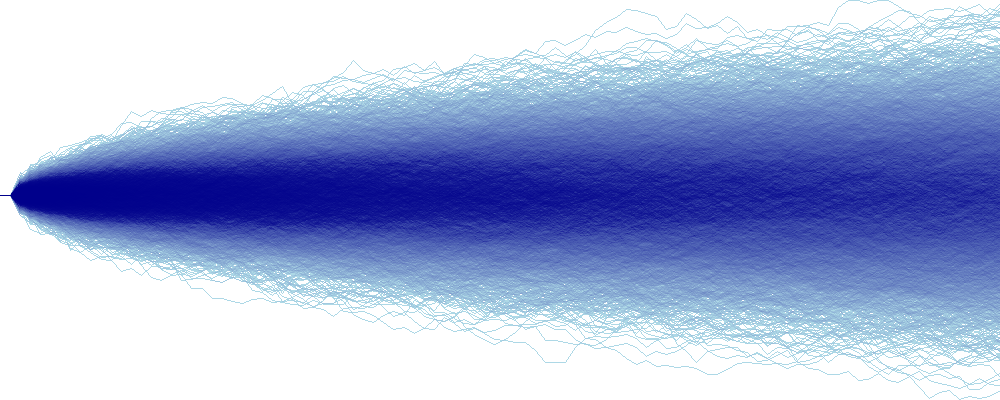

In [5]:
n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0)
img = tf.shade(agg, how='eq_hist')

img

# NN Approach

In [6]:
network = MLP(decomp_dim=decomp_dim)
mtloss = MultiTaskLoss(num_losses=4)
optimizer = torch.optim.Adam(params=[*network.parameters(), 
                                     *mtloss.parameters()],
                             lr=learning_rate)

In [19]:
loss_vals = {}
sigma_tracker = {}
kappa_tracker = {}
for episode in tqdm(range(num_episodes), position=0, leave=True):
    loss_vals[episode] = []
    sigma_tracker[episode] = []
    kappa_tracker[episode] = []

    # for batch_index in tqdm(range(1, int(num_paths/batch_size)+1), position=1, leave=False):
    for batch_index in range(1, int(num_paths/batch_size)+1):
        lower_bound = int((batch_index-1)*batch_size)
        upper_bound = int((batch_index)*batch_size)

        true_vals = sim_prices[:, lower_bound:upper_bound]
        batch_nu_vals = nu_vals[:, lower_bound:upper_bound]

        for timestep in range(0, num_timesteps-1):
            true_vals_t = torch.FloatTensor(true_vals[timestep, :])
            true_vals_t_plus_one = torch.FloatTensor(true_vals[timestep+1, :])
            batch_nu_vals_t = batch_nu_vals[timestep]
            price_impacts = network.permenant_price_impact_func(torch.FloatTensor(batch_nu_vals_t)).flatten()

            time_tensor = torch.FloatTensor([timestep*dt])
            f_vals = network(time_tensor)
            K_t_t = network.approx_func(time_tensor.reshape(-1,1), time_tensor.reshape(-1,1)).flatten()

            # Calculate first f(X_t, t; \theta) term
            f_x_t_one = price_impacts * K_t_t

            # Calculate Second f(X_t, t; \theta) term
            # Calcutate f_n'(t)
            grad_time_tensor = torch.FloatTensor([timestep*dt]) 
            grad_time_tensor.requires_grad = True
            f_prime_vals = torch.autograd.functional.jacobian(network, 
                                                              time_tensor, 
                                                              create_graph=True)
            f_prime_vals = f_prime_vals.flatten()

            all_time_tensor = (torch.arange(0, timestep)*dt).reshape(-1,1)
            B_n_t = torch.zeros((1, batch_size, decomp_dim))
            d_B_n_s = network(all_time_tensor).reshape(timestep, 
                                                        1,
                                                        decomp_dim)\
                      * network.permenant_price_impact_func(torch.FloatTensor(batch_nu_vals[:timestep])).reshape(timestep, 
                                                                                                batch_size, 
                                                                                                1) * dt

            B_n_t = torch.vstack([B_n_t, d_B_n_s])[:-1]
            B_n_t = torch.sum(B_n_t, dim=0)

            f_x_t_two = (B_n_t * f_prime_vals.reshape(1,decomp_dim)).sum(dim=1)
            f_x_t = f_x_t_one + f_x_t_two
            L_x_t = network.sigma
            loss_term_one = 0.5 * torch.log(2 * torch.pi * torch.abs((L_x_t**2)*dt))
            loss_term_two_temp = ((true_vals_t_plus_one - true_vals_t) - f_x_t*dt)
            loss_term_two = 0.5*(loss_term_two_temp**2) / ((L_x_t**2)*dt)

            likely_hood_loss = (loss_term_one+loss_term_two).mean()

            ##################################################################################
            ##################################################################################
            ##################################################################################
            # Enforcing K(t,t) = K(s,s) 
            time_one = torch.FloatTensor(rng.uniform(0, num_timesteps, batch_size)).reshape(-1,1)*dt
            time_two = torch.FloatTensor(rng.uniform(0, num_timesteps, batch_size)).reshape(-1,1)*dt
            K_one_two = network.approx_func(time_one, time_two)

            true_val = torch.FloatTensor(kernel_function(time_one.detach().numpy(), 
                                                 time_two.detach().numpy())).flatten()

            true_error = torch.pow(true_val-K_one_two, 2)

            K_one_one = network.approx_func(time_one, time_one).flatten()
            K_two_two = network.approx_func(time_two, time_two).flatten()

            kernel_error_one = torch.pow(K_one_one-torch.FloatTensor([K0]), 2)
            kernel_error_two = torch.pow(K_two_two-torch.FloatTensor([K0]), 2)
            kernel_error_three = torch.pow(K_one_one-K_two_two, 2)

            # Translation Invariance 
            delta = torch.FloatTensor(rng.uniform(-num_timesteps,
                                                  num_timesteps, 
                                                  batch_size)).reshape(-1,1)*dt

            time_one_delta = time_one + delta
            time_two_delta = time_two + delta
            K_one_two_delta = network.approx_func(time_one_delta, time_two_delta).flatten()
            kernel_error_four = torch.pow(K_one_two-K_one_two_delta, 2)

            kernel_error = (
                            # true_error.detach().mean().item(),
                            kernel_error_one.detach().mean().item(), 
                            kernel_error_two.detach().mean().item(), 
                            kernel_error_three.detach().mean().item(),
                            # kernel_error_four.detach().mean().item(),
                            # asymtopic_loss.detach().mean().item()
                            )
            ##################################################################################
            ##################################################################################

            loss_tensor = torch.hstack([
                                        likely_hood_loss, 
                                        # true_error.mean(),
                                        kernel_error_one.mean(), 
                                        kernel_error_two.mean(),
                                        kernel_error_three.mean(),
                                        # kernel_error_four.mean(),
                                        # asymtopic_loss.mean()
                                        ])

            if len(loss_tensor) == 1:
                loss = loss_tensor.mean()
            else:
                loss = mtloss(loss_tensor)

            # Tracker Updates
            kappa_tracker[episode].append(network.kappa.detach().item())
            sigma_tracker[episode].append(network.sigma.detach().item())
            loss_vals[episode].append({'mt_loss': loss.detach().item(),
                                       **{f'kernel_loss_{_}': item for _, item in enumerate(kernel_error)},
                                       'likelyhood_loss': likely_hood_loss.detach().item()})

            network.zero_grad()
            optimizer.zero_grad()

            loss.backward()
            # torch.nn.utils.clip_grad_norm_(network.parameters(), 1)
            optimizer.step()

            network.zero_grad()
            optimizer.zero_grad()

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

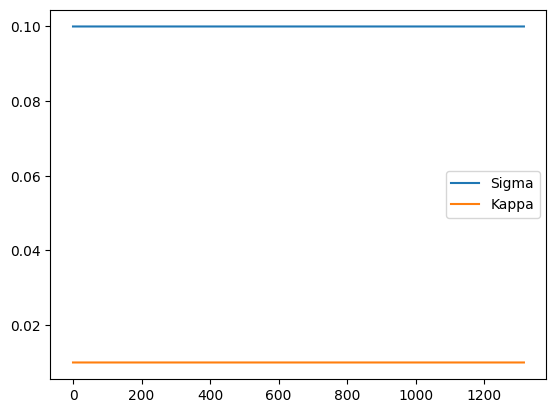

In [20]:
plt.plot(np.hstack([np.array(_) for _ in sigma_tracker.values()]), label='Sigma')
plt.plot(np.hstack([np.array(_) for _ in kappa_tracker.values()]), label='Kappa')

plt.legend()
plt.show()

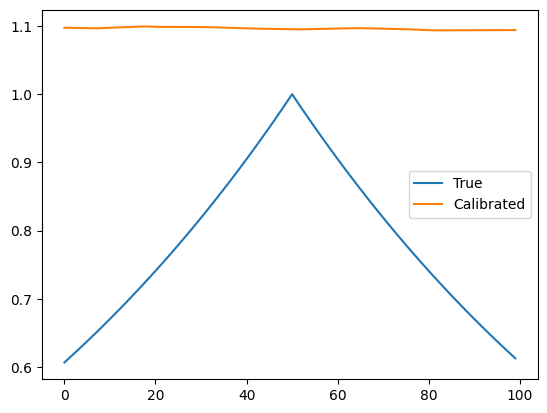

In [24]:
s_val = 50
kernel_plot = []
kernel_plot_two = []

for i in range(0, num_timesteps):
    k_s_t = network.approx_func(torch.FloatTensor([s_val*dt]).reshape(-1,1), torch.FloatTensor([i*dt]).reshape(1,-1))
    kernel_plot.append(k_s_t.detach().item())

partial_func = partial(kernel_function, y=s_val*dt)
for i in range(0, num_timesteps):
    val = partial_func(i*dt)
    kernel_plot_two.append(val)

plt.plot(kernel_plot_two, label='True')
plt.plot(kernel_plot, label='Calibrated')
plt.legend()
plt.show()

# Validation Prices

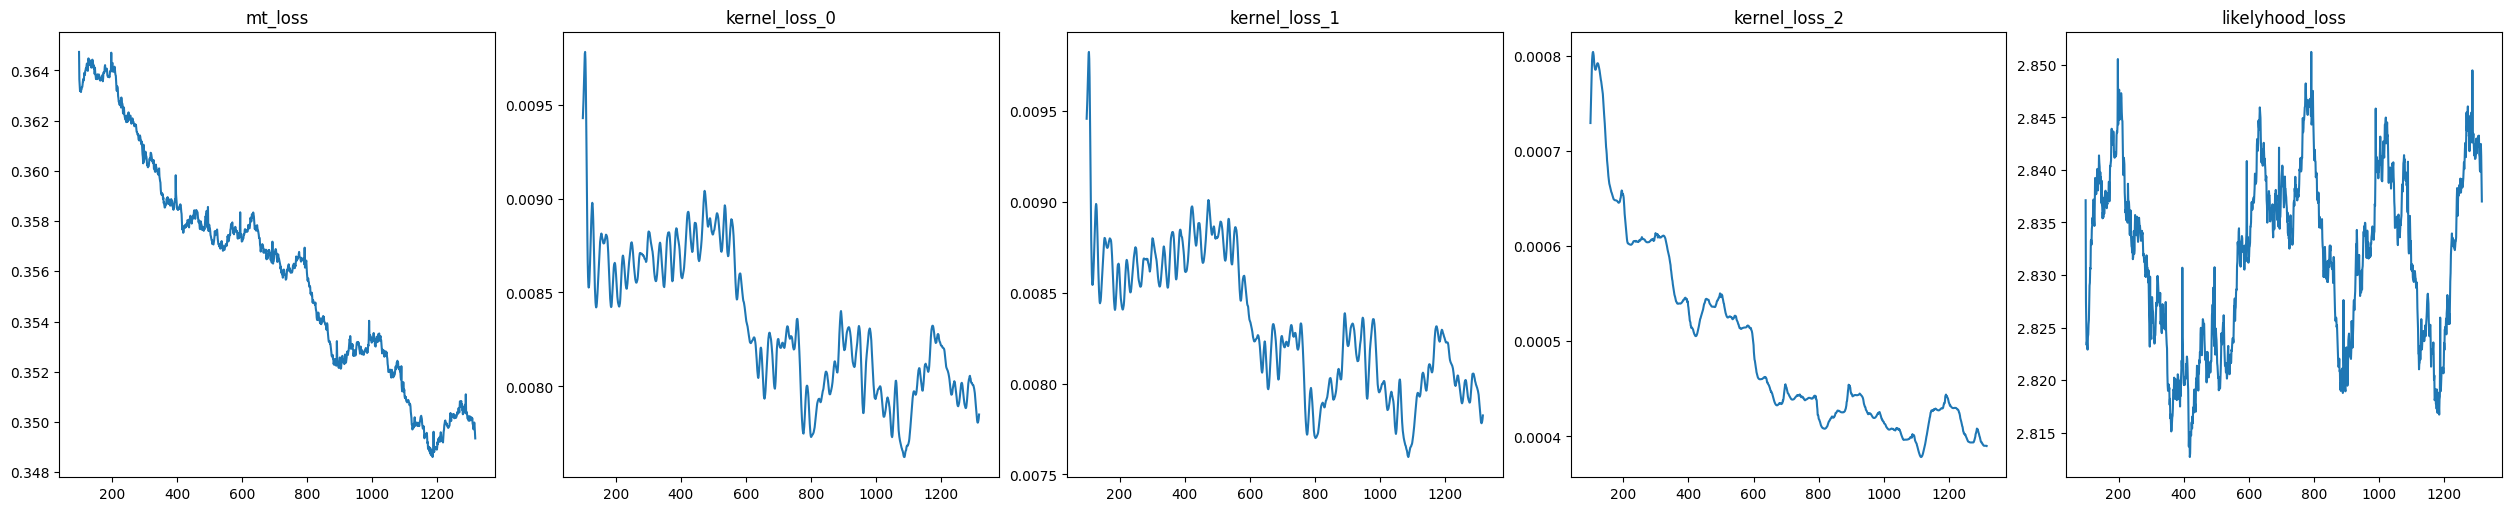

In [23]:
loss_types = tuple(loss_vals[0][0].keys())

fig, ax = plt.subplots(1, len(loss_types), figsize=(5*len(loss_types), 5), constrained_layout=True)

for plot_index, loss_type in enumerate(loss_types):
    ax[plot_index].plot(pd.concat([
        pd.DataFrame(loss_vals[_])[loss_type][:] for _ in loss_vals.keys()
        ]).rolling(num_timesteps).mean().values)

    ax[plot_index].set_title(loss_type)

plt.show()

# Distribution Plots

In [ ]:
val_nu_vals = rng.uniform(-50, 100,size=(num_timesteps, 10_000))
val_inital_prices = np.ones((1, 10_000)) * initial_price
val_sim_prices, _ = non_markovian_midprice(inital_prices=val_inital_prices,
                             permenant_price_impact_func=permenant_price_impact_func,
                             nu_vals=val_nu_vals,
                             kernel_function=kernel_function,
                             dt=dt,
                             rng=rng,
                             num_paths=10_000,
                             num_timesteps=num_timesteps,
                             sigma=sigma_true)

In [ ]:
num_paths = 10000

sim_nu_vals = rng.uniform(-50, 100,size=(num_timesteps, num_paths))
all_time_tensor = (torch.arange(0, num_timesteps)*dt).reshape(-1,1)

noise =  np.zeros((1, num_paths))
d_W_t = network.sigma.detach().item() * rng.standard_normal(size=(num_timesteps, num_paths)) * (dt**0.5)
noise = np.vstack([noise, d_W_t])

S_t = torch.ones((1, num_paths)) * initial_price
B_n_t = torch.zeros((1, num_paths, decomp_dim)).detach().numpy()

d_B_n_s = network(all_time_tensor).detach().numpy().reshape(num_timesteps, 
                                                            1,
                                                            decomp_dim)\
          * network.numpy_permenant_price_impact_func(sim_nu_vals).reshape(num_timesteps, num_paths, 1) * dt

B_n_t = np.vstack([B_n_t, d_B_n_s])
B_n_t = np.cumsum(B_n_t, axis=0)[:-1]

f_prime_t = torch.vstack([torch.autograd.functional.jacobian(network, 
                                                     _, 
                                                     create_graph=True).flatten() 
                                                     for _ in all_time_tensor]).detach().numpy().reshape(num_timesteps, 
                                                                                                         1, 
                                                                                                         decomp_dim)

dt_term_one = network.numpy_permenant_price_impact_func(sim_nu_vals).reshape(num_timesteps, 
                                                                             num_paths) * network.approx_func(all_time_tensor, 
                                                                                                              all_time_tensor).detach().numpy().reshape(num_timesteps, 1)
dt_term_two = (f_prime_t * B_n_t).sum(axis=2)

dt_term = (dt_term_one + dt_term_two)*dt

d_S_terms = dt_term + d_W_t

S_t = np.vstack([S_t, d_S_terms])
S_t = np.cumsum(S_t, axis=0)

nn_sim_prices = S_t

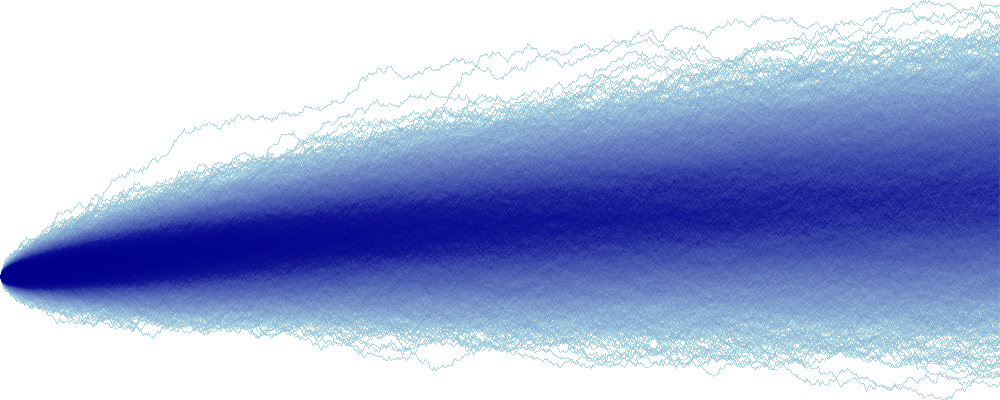

In [ ]:
n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(nn_sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0)
img = tf.shade(agg, how='eq_hist')

img

# Distribution Plots

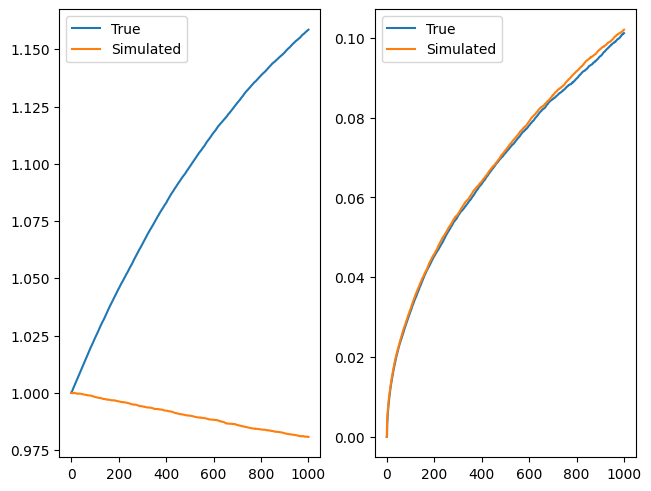

In [ ]:
fig, ax = plt.subplots(1,2, constrained_layout=True)

ax[0].plot(val_sim_prices[:, :10_000].mean(axis=1), label='True')
ax[0].plot(nn_sim_prices.mean(axis=1), label='Simulated')
ax[0].legend()

ax[1].plot(val_sim_prices[:, :10_000].std(axis=1), label='True')
ax[1].plot(nn_sim_prices.std(axis=1), label='Simulated')
ax[1].legend()

plt.show()

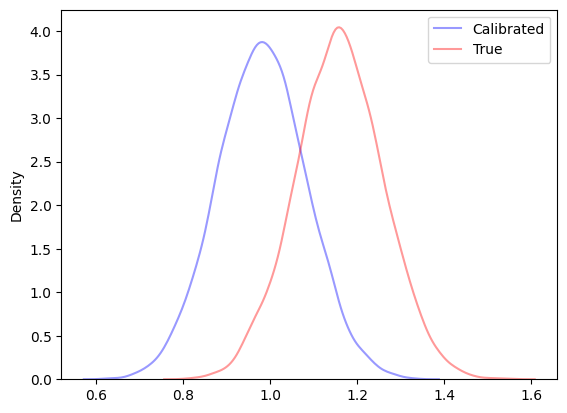

In [ ]:
final_sim_prices = nn_sim_prices[-1]
final_val_sim_prices = val_sim_prices[-1]

sns.kdeplot(final_sim_prices, alpha=0.4, color='blue', label='Calibrated')
sns.kdeplot(final_val_sim_prices, alpha=0.4, color='red', label='True')
plt.legend()
plt.show()